# Convert CIF to JCPDS

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

* This notebook shows how to make an XRD plot using `pymatgen`.

* This also aims to show how to read `CIF` files, convert them to `JCPDS`.

* Note that `ds_jcpds` is differernt from that in `PeakPo`, but it produces readable jcpds for PeakPo.

In [2]:
import pymatgen as mg
from pymatgen import Lattice, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
mg.__version__

'2019.4.11'

This works with `pymatgen` version `2019.4.11`.

In [4]:
# import sys
# sys.path.insert(0, '../peakpo')
import ds_jcpds

## Input parameters

In [5]:
fn_cif = "./MgSiO3_bm.cif"
fn_jcpds = './MgSiO3-bm.jcpds'
comments_jcpds = "Bridgmanite"

In [6]:
k0 = 260.
k0p = 4.00
alpha = 3.16e-5

In [7]:
wl_xray = 0.3344
xrange = (0,40)

## Read CIF

The `cif` file below was downloaded from American mineralogist crystal structure database.

In [8]:
material = mg.Structure.from_file(fn_cif)

## Get some parameters in CIF

In [9]:
print('Unit-cell volume = ', material.volume)
print('Density = ', material.density)
print('Chemical formula = ', material.formula)

Unit-cell volume =  162.345450996792
Density =  4.107275060713392 g cm^-3
Chemical formula =  Mg4 Si4 O12


## Get lattice parameters from CIF

In [10]:
lattice = material.lattice
print('Lattice parameters = ', lattice.a, lattice.b, lattice.c, \
      lattice.alpha, lattice.beta, lattice.gamma)
crystal_system = SpacegroupAnalyzer(material).get_crystal_system()
print(crystal_system)

Lattice parameters =  4.7754 4.9292 6.8969 90.0 90.0 90.0
orthorhombic


## Get diffraction pattern

In [11]:
c = XRDCalculator(wavelength=wl_xray)

In [12]:
pattern = c.get_pattern(material, two_theta_range = xrange)

## Extract twotheta, d-sp, int, hkl

In [13]:
pattern.hkls[0][0]['hkl']

(1, 0, 1)

In [14]:
pattern.hkls.__len__()

722

In [15]:
h = []; k = []; l = []
for i in range(pattern.hkls.__len__()):
    h.append(pattern.hkls[i][0]['hkl'][0])
    k.append(pattern.hkls[i][0]['hkl'][1])
    l.append(pattern.hkls[i][0]['hkl'][2])

In [16]:
d_lines = [pattern.x, pattern.d_hkls, pattern.y, h, k, l ]
diff_lines = np.transpose(np.asarray(d_lines))
print(diff_lines[1,:])

[5.55821414 3.44845    8.23481259 0.         0.         2.        ]


## Table output

In [17]:
table = pd.DataFrame(data = diff_lines,    # values
    columns=['Two Theta', 'd-spacing', 'intensity', 'h', 'k', 'l'])  # 1st row as the column names
table.head()

,Two Theta,d-spacing,intensity,h,k,l
0,4.881525,3.926131,0.815361,1.0,0.0,1.0
1,5.558214,3.448450,8.234813,0.0,0.0,2.0
2,5.588459,3.429802,20.916571,1.0,1.0,0.0
3,6.241956,3.071022,8.938528,1.0,1.0,1.0
4,7.779938,2.464600,24.497625,0.0,2.0,0.0


## Plot peak positions generated from pymatgen

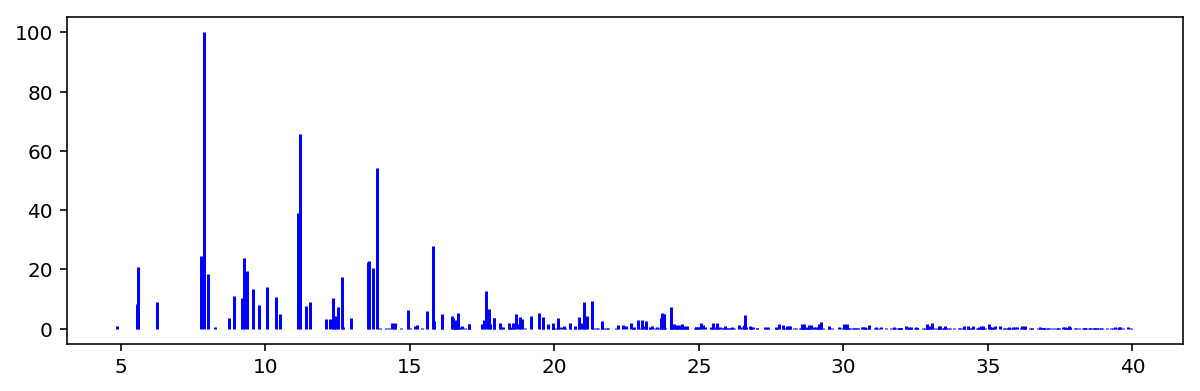

In [18]:
f = plt.figure(figsize=(10,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b');

## Convert to JCPDS

Setup an `jcpds` object from a `cif` file

In [19]:
material_jcpds = ds_jcpds.JCPDS()
material_jcpds.set_from_cif(fn_cif, k0, k0p, \
                      thermal_expansion=alpha, two_theta_range=xrange)

Calculate diffraction pattern at a pressure.

In [20]:
material_jcpds.cal_dsp(pressure = 100.)
dl = material_jcpds.get_DiffractionLines()
tth, inten = material_jcpds.get_tthVSint(wl_xray)

(7.5, 9)

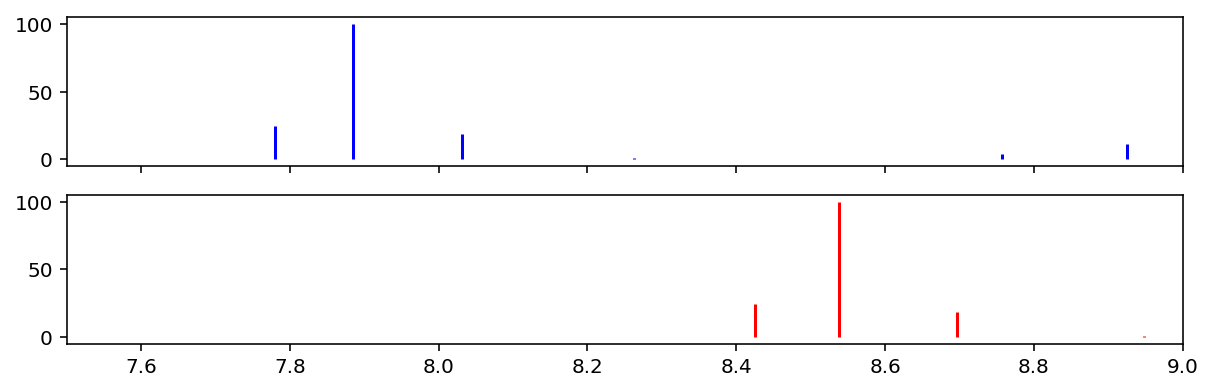

In [21]:
f, ax = plt.subplots(2, 1, figsize=(10,3), sharex=True)
ax[0].vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
ax[1].vlines(tth, 0., inten, color = 'r')
ax[0].set_xlim(7.5,9)

## Save to a JCPDS file

In [22]:
material_jcpds.write_to_file(fn_jcpds, comments=comments_jcpds)

#$ Read back the written JCPDS for test

In [23]:
material_test = ds_jcpds.JCPDS(filename = fn_jcpds)

Calculate a pattern at a pressure

In [24]:
material_test.cal_dsp(pressure = 100.)
material_test.get_DiffractionLines()
tth, inten = material_test.get_tthVSint(wl_xray)

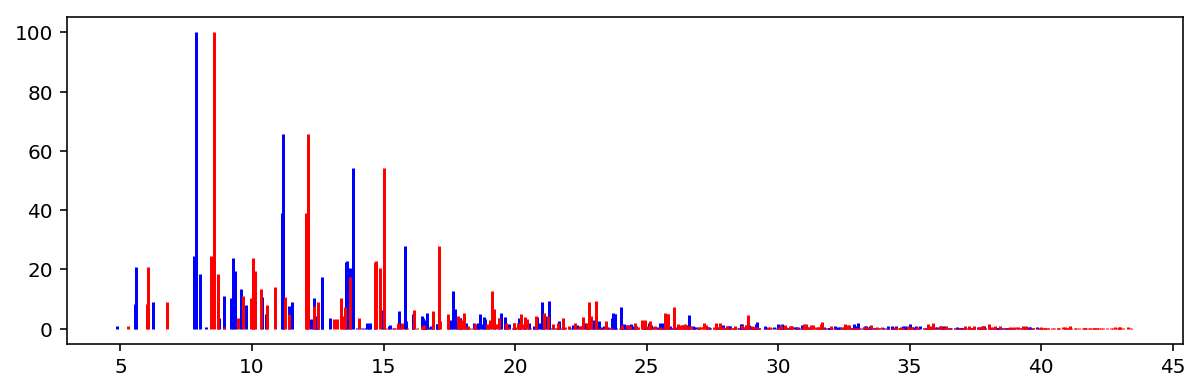

In [25]:
f = plt.figure(figsize=(10,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
plt.vlines(tth, 0., inten, color = 'r');